# Breast Cancer Cell Prediction Example
This is based on parts of the caffe2 MNIST tutorials at https://github.com/caffe2/tutorials/blob/master/create_your_own_dataset.ipynb and https://github.com/caffe2/tutorials/blob/master/MNIST.ipynb and uses six public NASA satellite images.



In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
import skimage
from skimage import io

In [7]:
from sklearn.feature_extraction import image

In [8]:
import os

In [9]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import numpy as np
from matplotlib import pyplot
from io import StringIO
import operator

from caffe2.proto import caffe2_pb2
import caffe2.python.predictor.predictor_exporter as pe
from caffe2.python import (
    brew,
    core,
    utils,
    model_helper,
    net_drawer,
    optimizer,
    visualize,
    workspace,
)

In [10]:
def my_db_input(model, blobs_out, batch_size, db, db_type):
    dbreader_name = "dbreader_" + db
    dbreader = model.param_init_net.CreateDB(
        [],
        dbreader_name,
        db=db,
        db_type=db_type,
    )
    return model.net.TensorProtosDBInput(
dbreader, blobs_out, batch_size=batch_size)

brew.Register(my_db_input)

# Load Field Images
There are six images of fields in different geographical locations.  They look different and we will train a LeNet to distinguish patches between the locations using caffe2.

In [11]:
%%bash
cd data
mkdir -p WDBC_images
cd WDBC_images
wget -q ftp://ftp.cs.wisc.edu/math-prog/cpo-dataset/machine-learn/cancer/cancer_images/*.gif

In [12]:
[_ for _ in os.listdir('data/WDBC_images') if _.endswith('.gif')]

['92_4934.gif',
 '92_5292.gif',
 '92_5291.gif',
 '92_5277.gif',
 '92_4632.gif',
 '92_5236.gif',
 '92_6954.gif',
 '92_6125.gif',
 '91_5691.gif',
 '92_5622.gif',
 '92_6682.gif',
 '92_751.gif',
 '92_5311.gif',
 '92_4342.gif',
 '91_9555.gif',
 '91_6838.gif',
 '92_7241.gif',
 '92_6424.gif',
 '91_6799.gif',
 '92_4964.gif']

In [13]:
from caffe2.python import visualize

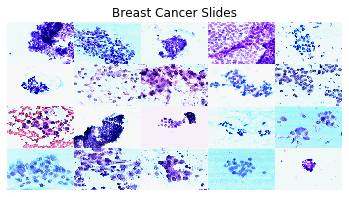

In [14]:
images = []
for filename in os.listdir('data/WDBC_images'):
    if filename.endswith('.gif'):
        img = io.imread('data/WDBC_images/%s'%filename)
        images.append(img[:,:,:3].tolist())
images = np.array(images)
images = np.moveaxis(images,3,1)
pyplot.figure()
pyplot.title("Breast Cancer Slides")
_ = visualize.NCHW.ShowMultiple(images/255.0)

In [15]:
benign_images = """92_751 
92_5311
92_5292
92_5291
92_5277
92_5236
92_4964
92_4934
92_4632
92_4342""".split()
benign_images

['92_751',
 '92_5311',
 '92_5292',
 '92_5291',
 '92_5277',
 '92_5236',
 '92_4964',
 '92_4934',
 '92_4632',
 '92_4342']

In [16]:
malignant_images = """92_7241
92_6954
92_6682
92_6424
92_6125
92_5622
91_9555
91_6838
91_6799
91_5691""".split()
malignant_images

['92_7241',
 '92_6954',
 '92_6682',
 '92_6424',
 '92_6125',
 '92_5622',
 '91_9555',
 '91_6838',
 '91_6799',
 '91_5691']

In [17]:
image_classes = dict(zip(
    benign_images + malignant_images,
    ['benign']*len(benign_images) + ['malignant']*len(malignant_images),
))
image_classes

{'92_751': 'benign',
 '92_5311': 'benign',
 '92_5292': 'benign',
 '92_5291': 'benign',
 '92_5277': 'benign',
 '92_5236': 'benign',
 '92_4964': 'benign',
 '92_4934': 'benign',
 '92_4632': 'benign',
 '92_4342': 'benign',
 '92_7241': 'malignant',
 '92_6954': 'malignant',
 '92_6682': 'malignant',
 '92_6424': 'malignant',
 '92_6125': 'malignant',
 '92_5622': 'malignant',
 '91_9555': 'malignant',
 '91_6838': 'malignant',
 '91_6799': 'malignant',
 '91_5691': 'malignant'}

### Extract random 60x60 RGB patches from each image

In [18]:
np.random.seed(123)
features = []
str_labels = []
for filename in os.listdir('data/WDBC_images'):
    if filename.endswith('.gif'):
        img = io.imread('data/WDBC_images/%s'%filename)
        patches = image.extract_patches_2d(img, (60, 60), 1000)[:,:,:,:3]
        patches = patches[patches.var((1,2,3))>50,:,:,:] #discard patches with no cells
        features += patches.tolist()
        str_labels += [image_classes[filename.split('.')[0]]]*len(patches)
features = np.array(features)
str_labels = np.array(str_labels)

### Convert to NCWH format

In [19]:
features = np.moveaxis(features,3,1)

In [20]:
features.shape,str_labels.shape

((16145, 3, 60, 60), (16145,))

### Check some patches
Each of these patches come from a known geographical location.  The LeNet will learn to predict where a patch came from.

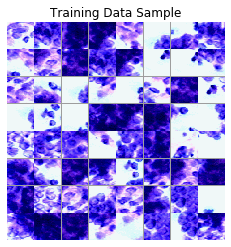

In [111]:
pyplot.figure()
pyplot.title("Training Data Sample")
_ = visualize.NCHW.ShowMultiple(features[:64]/255.0)

### Build a mapping from location to unique integer id
The integers in labels will be used by caffe2 for one-hot-encoding later.

In [112]:
loc2id = dict(zip(sorted(set(str_labels)),range(len(set(str_labels)))))
loc2id

{'benign': 0, 'malignant': 1}

In [113]:
id2loc = dict(zip(range(len(set(str_labels))),sorted(set(str_labels))))
id2loc

{0: 'benign', 1: 'malignant'}

In [114]:
labels = np.array([loc2id[_] for _ in str_labels])

## Extract a random set of patches for training
Use the rest for testing

In [115]:
np.random.seed(123)

random_index = np.random.permutation(len(str_labels))
features = features[random_index]
labels = labels[random_index]

ntrain = 2000
ntest = len(features)-ntrain

train_features = features[:ntrain]
train_labels = labels[:ntrain]
test_features = features[ntrain:]
test_labels = labels[ntrain:]

ntrain,ntest

(2000, 14682)

### Write the train and test sets to minidb files
Caffe2 will use these as inputs

In [116]:
data_folder = os.path.join('data/WDBC_images')
train_path = os.path.join(data_folder,'geo_train.minidb')
test_path = os.path.join(data_folder,'geo_test.minidb')

In [117]:
def write_db(db_type, db_name, features, labels):
    if os.path.exists(db_name):
        os.unlink(db_name)
    db = core.C.create_db(db_type, db_name, core.C.Mode.write)
    transaction = db.new_transaction()
    for i in range(features.shape[0]):
        feature_and_label = caffe2_pb2.TensorProtos()
        feature_and_label.protos.extend([
            utils.NumpyArrayToCaffe2Tensor(features[i]),
            utils.NumpyArrayToCaffe2Tensor(labels[i])])
        transaction.put(
            'train_%03d'.format(i),
            feature_and_label.SerializeToString())
    # Close the transaction, and then close the db.
    del transaction
    del db

write_db("minidb", train_path, train_features, train_labels)
write_db("minidb", test_path, test_features, test_labels)

## Define functions derived from caffe2 MNIST tutorial
https://github.com/caffe2/tutorials/blob/master/MNIST.ipynb

In [118]:
def AddInput(model, batch_size, db, db_type):
    ### load the data from db - Method 1 using brew
    data_uint8, label = brew.my_db_input(
        model,
        blobs_out=["data_uint8", "label"],
        batch_size=batch_size,
        db=db,
        db_type=db_type,
    )
    ### load the data from db - Method 2 using TensorProtosDB
    #data_uint8, label = model.TensorProtosDBInput(
    #    [], ["data_uint8", "label"], batch_size=batch_size,
    #    db=db, db_type=db_type)
    
    # cast the data to float
    data = model.Cast(data_uint8, "data", to=core.DataType.FLOAT)
    # scale data from [0,255] down to [0,1]
    data = model.Scale(data, data, scale=float(1./256))
    # don't need the gradient for the backward pass
    data = model.StopGradient(data, data)
    return data, label

In [119]:
def AddModel(model, data):
    '''
    This is LeNet for color images, with an extra layer supporting a 60x60 receptive field
    '''
    # Image size: 60 x 60 -> 56 x 56
    conv0 = brew.conv(model, data, 'conv0', dim_in=3, dim_out=20, kernel=5)
    # Image size: 56 x 56 -> 28 x 28
    pool0 = brew.max_pool(model, conv0, 'pool0', kernel=2, stride=2)
    # Image size: 28 x 28 -> 24 x 24
    conv1 = brew.conv(model, pool0, 'conv1', dim_in=20, dim_out=20, kernel=5)
    # Image size: 24 x 24 -> 12 x 12
    pool1 = brew.max_pool(model, conv1, 'pool1', kernel=2, stride=2)
    # Image size: 12 x 12 -> 8 x 8
    conv2 = brew.conv(model, pool1, 'conv2', dim_in=20, dim_out=50, kernel=5)
    # Image size: 8 x 8 -> 4 x 4
    pool2 = brew.max_pool(model, conv2, 'pool2', kernel=2, stride=2)
    # 50 * 4 * 4 stands for dim_out from previous layer multiplied by the image size
    # Here, the data is flattened from a tensor of dimension 50x4x4 to a vector of length 50*4*4
    fc3 = brew.fc(model, pool2, 'fc3', dim_in=50 * 4 * 4, dim_out=500)
    relu3 = brew.relu(model, fc3, 'relu3')
    # Last FC Layer
    pred = brew.fc(model, relu3, 'pred', dim_in=500, dim_out=len(loc2id))
    # Softmax Layer
    softmax = brew.softmax(model, pred, 'softmax')
    
    return softmax

In [120]:
def AddAccuracy(model, softmax, label):
    """Adds an accuracy op to the model"""
    accuracy = brew.accuracy(model, [softmax, label], "accuracy")
    return accuracy

In [121]:
def AddTrainingOperators(model, softmax, label):
    """Adds training operators to the model."""
    # Compute cross entropy between softmax scores and labels
    xent = model.LabelCrossEntropy([softmax, label], 'xent')
    # Compute the expected loss
    loss = model.AveragedLoss(xent, "loss")
    # Track the accuracy of the model
    AddAccuracy(model, softmax, label)
    # Use the average loss we just computed to add gradient operators to the model
    model.AddGradientOperators([loss])
    # Specify the optimization algorithm
    optimizer.build_adagrad(model,base_learning_rate=0.001)
    #optimizer.build_sgd(
    #    model,
    #    base_learning_rate=0.001,
    #    policy="step",
    #    stepsize=1,
    #    gamma=0.999,
    #)

In [122]:
def enableGPU(model):
    if False:#workspace.has_gpu_support: #caffe2 tutorial does not current support GPU
        print("GPU :-)")
        model.param_init_net.RunAllOnGPU()
        return model.net.RunAllOnGPU() 
    else:
        print ("No GPU :-(")
        return model

### Define the train, test, and deploy models using the functions above

In [123]:
#### Train Model
# Specify the data will be input in NCHW order
#  (i.e. [batch_size, num_channels, height, width])
arg_scope = {"order": "NCHW"}
# Create the model helper for the train model
train_model = model_helper.ModelHelper(name="geo_train", arg_scope=arg_scope)
enableGPU(train_model)
# Specify the input is from the train lmdb
data, label = AddInput(
    train_model, batch_size=64,
    db=os.path.join(data_folder, 'geo_train.minidb'),
    db_type='minidb')
# Add the model definition (fc layers, conv layers, softmax, etc.)
softmax = AddModel(train_model, data)
# Add training operators, specify loss function and optimization algorithm
AddTrainingOperators(train_model, softmax, label)
# Add bookkeeping operators to save stats from training
#AddBookkeepingOperators(train_model)

#### Testing model. 
# We will set the batch size to 100, so that the testing
#   pass is 100 iterations (10,000 images in total).
#   For the testing model, we need the data input part, the main AddModel
#   part, and an accuracy part. Note that init_params is set False because
#   we will be using the parameters obtained from the train model which will
#   already be in the workspace.
test_model = model_helper.ModelHelper(
    name="geo_test", arg_scope=arg_scope, init_params=False)
enableGPU(test_model)
data, label = AddInput(
    test_model, batch_size=ntest,
    db=os.path.join(data_folder, 'geo_test.minidb'),
    db_type='minidb')
softmax = AddModel(test_model, data)
AddAccuracy(test_model, softmax, label)

#### Deployment model. 
# We simply need the main AddModel part.
deploy_model = model_helper.ModelHelper(
    name="geo_deploy", arg_scope=arg_scope, init_params=False)
enableGPU(test_model)
AddModel(deploy_model, "data")

No GPU :-(
No GPU :-(
No GPU :-(


BlobReference("softmax")

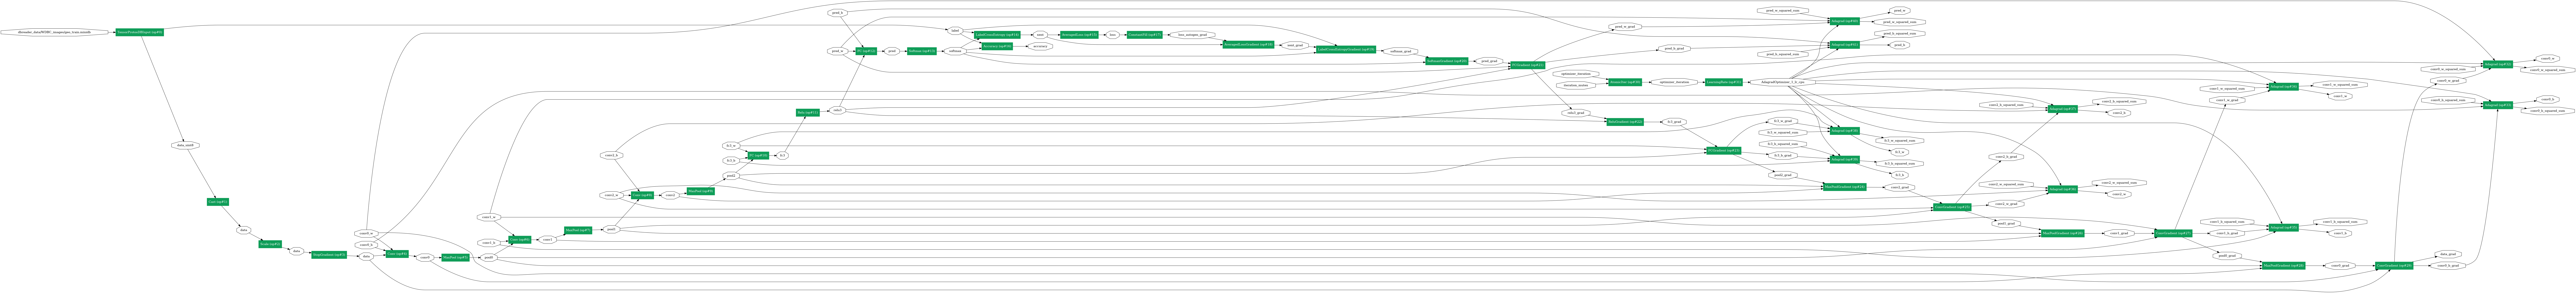

In [124]:
from IPython import display
graph = net_drawer.GetPydotGraph(train_model.net.Proto().op, "geo", rankdir="LR")
display.Image(graph.create_png(), width=800)

## Initialize the train model

In [125]:
# The parameter initialization network only needs to be run once.
# Now all the parameter blobs are initialized in the workspace.
workspace.RunNetOnce(train_model.param_init_net)

# Creating an actual network as a C++ object in memory.
#   We need this as the object is going to be used a lot
#   so we avoid creating an object every single time it is used.
# overwrite=True allows you to run this cell several times and avoid errors
workspace.CreateNet(train_model.net, overwrite=True)


True

### Train and track progress

In [126]:
# Set the iterations number and track the accuracy & loss
total_iters = 1000
accuracy = []
loss = []

# MAIN TRAINING LOOP!
# Now, we will manually run the network for 200 iterations. 
for i in range(total_iters):
    workspace.RunNet(train_model.net)
    # Check the accuracy and loss every so often
    if i % 25 == 0:
        accuracy.append(workspace.blobs['accuracy'])
        loss.append(workspace.blobs['loss'])
        print("Iter: {}, Loss: {}, Accuracy: {}".format(i,loss[-1],accuracy[-1]))



Iter: 0, Loss: 0.7457144856452942, Accuracy: 0.4375
Iter: 25, Loss: 0.6441560983657837, Accuracy: 0.671875
Iter: 50, Loss: 0.5745359659194946, Accuracy: 0.6875
Iter: 75, Loss: 0.620918869972229, Accuracy: 0.609375
Iter: 100, Loss: 0.5608875155448914, Accuracy: 0.703125
Iter: 125, Loss: 0.5227842330932617, Accuracy: 0.796875
Iter: 150, Loss: 0.5721365809440613, Accuracy: 0.703125
Iter: 175, Loss: 0.5497521162033081, Accuracy: 0.703125
Iter: 200, Loss: 0.5961734056472778, Accuracy: 0.640625
Iter: 225, Loss: 0.5207780599594116, Accuracy: 0.71875
Iter: 250, Loss: 0.4803605079650879, Accuracy: 0.84375
Iter: 275, Loss: 0.5642075538635254, Accuracy: 0.75
Iter: 300, Loss: 0.5327974557876587, Accuracy: 0.71875
Iter: 325, Loss: 0.56452476978302, Accuracy: 0.59375
Iter: 350, Loss: 0.4828149080276489, Accuracy: 0.71875
Iter: 375, Loss: 0.45778727531433105, Accuracy: 0.828125
Iter: 400, Loss: 0.48819687962532043, Accuracy: 0.796875
Iter: 425, Loss: 0.5199766159057617, Accuracy: 0.78125
Iter: 450, L

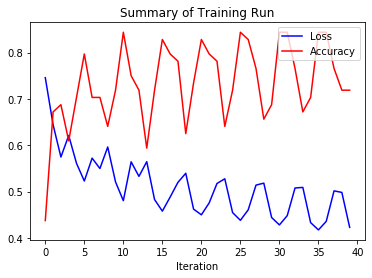

In [127]:
# After the execution is done, let's plot the values.
pyplot.plot(loss, 'b')
pyplot.plot(accuracy, 'r')
pyplot.title("Summary of Training Run")
pyplot.xlabel("Iteration")
pyplot.legend(('Loss', 'Accuracy'), loc='upper right')

### View some training data and a prediction

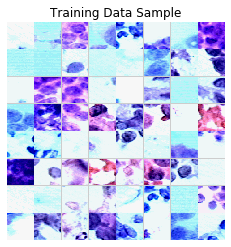

In [128]:
pyplot.figure()
pyplot.title("Training Data Sample")
data = workspace.FetchBlob('data')
_ = visualize.NCHW.ShowMultiple(data)

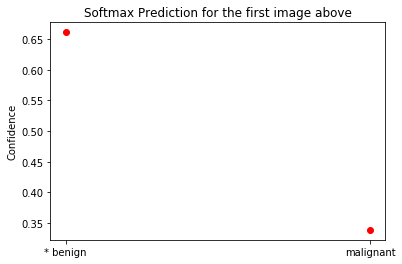

In [129]:
pyplot.figure()
pyplot.title('Softmax Prediction for the first image above')
pyplot.ylabel('Confidence')

softmax = workspace.FetchBlob('softmax')
truth = workspace.FetchBlob('label')
ticks = sorted(loc2id)
showidx = 0
ticks[truth[showidx]] = '* %s'%ticks[truth[showidx]]
pyplot.xticks(range(len(loc2id)),ticks)
_ = pyplot.plot(softmax[showidx], 'ro')

In [130]:
# param_init_net here will only create a data reader
# Other parameters won't be re-created because we selected init_params=False before
workspace.RunNetOnce(test_model.param_init_net)
workspace.CreateNet(test_model.net, overwrite=True)

True

### Assess Accuracy on the Test Set

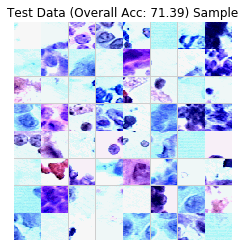

In [131]:
workspace.RunNet(test_model.net)
test_accuracy = workspace.FetchBlob('accuracy')

pyplot.figure()
pyplot.title("Test Data (Overall Acc: %.2f) Sample"%(100*test_accuracy))
data = workspace.FetchBlob('data')
_ = visualize.NCHW.ShowMultiple(data[:64])

In [ ]:
pyplot.figure()
pyplot.title('Softmax Prediction for the first image above')
pyplot.ylabel('Confidence')

softmax = workspace.FetchBlob('softmax')
truth = workspace.FetchBlob('label')
ticks = sorted(loc2id)
showidx = 0
ticks[truth[showidx]] = '* %s'%ticks[truth[showidx]]
pyplot.xticks(range(len(loc2id)),ticks)
_ = pyplot.plot(softmax[showidx], 'ro')

### Check some more predictions

In [133]:
import pandas as pd

In [134]:
preds = softmax.argmax(1)
pd.DataFrame(list(zip(
    range(len(truth)),
    [id2loc[_] for _ in truth],
    [id2loc[_] for _ in preds]
))[:12],columns=['index','Truth','Prediction'])

,index,Truth,Prediction
0,0,benign,benign
1,1,benign,benign
2,2,benign,malignant
3,3,malignant,malignant
4,4,benign,malignant
5,5,malignant,malignant
6,6,benign,malignant
7,7,benign,benign
8,8,benign,malignant
9,9,malignant,malignant


### Deploy (write to file) the model

In [135]:
# construct the model to be exported
# the inputs/outputs of the model are manually specified.
pe_meta = pe.PredictorExportMeta(
    predict_net=deploy_model.net.Proto(),
    parameters=[str(b) for b in deploy_model.params] + ['accuracy','loss','label'], 
    inputs=["data"],
    outputs=["softmax"],
)

# save the model to a file. Use minidb as the file format
pe.save_to_db("minidb", os.path.join(data_folder, "geo_model.minidb"), pe_meta)
print("Deploy model saved to: " + data_folder + "/geo_model.minidb")

Deploy model saved to: data/WDBC_images/geo_model.minidb
